In [34]:
import binascii
import time
class Keccak:
   
    __STATE_LENGTH = 1600
    __DELIMITED_SUFFIX = 0x06
    __SHA3_RATE_LENGTH = 256
    def __init__(self,variant=2):
        self.__state_bytes_length = self.__STATE_LENGTH // 8
        self.__delimited_suffix = self.__DELIMITED_SUFFIX

        self.__SHA3_RATE_LENGTH = variant
        self.__rate_bytes_length = self.__SHA3_RATE_LENGTH // 8
        self.__state_in_bytes = bytearray([0 for i in range(self.__state_bytes_length)])
        self.__capacity_bytes_length = self.__state_bytes_length - self.__rate_bytes_length
        self.__hash_bytes_length = self.__capacity_bytes_length//2
        self.__hash_bytes = bytearray()
 
    
    @staticmethod
    def __rotate_word(word, n):
        return ((word >> (64 - (n % 64))) + (word << (n % 64))) % (1 << 64)

    @staticmethod
    def __load_64_bytes(byte_array):
        return sum((byte_array[i] << (8 * i)) for i in range(8))

    @staticmethod
    def __store_64_bytes(integer):
        return list((integer >> (8 * i)) % 256 for i in range(8))

    def __run_inner_hash_functions(self, lanes):
        R = 1
        for round in range(24):

            # θ
            C = [lanes[x][0] ^ lanes[x][1] ^ lanes[x][2] ^ lanes[x][3] ^ lanes[x][4] for x in range(5)]
            D = [C[(x + 4) % 5] ^ self.__rotate_word(C[(x + 1) % 5], 1) for x in range(5)]
            lanes = [[lanes[x][y] ^ D[x] for y in range(5)] for x in range(5)]

            # ρ and π
            (x, y) = (1, 0)
            current = lanes[x][y]
            for t in range(24):
                (x, y) = (y, (2 * x + 3 * y) % 5)
                (current, lanes[x][y]) = (lanes[x][y], self.__rotate_word(current, (t + 1) * (t + 2) // 2))

            # χ
            for y in range(5):
                T = [lanes[x][y] for x in range(5)]
                for x in range(5):
                    lanes[x][y] = T[x] ^ ((~T[(x + 1) % 5]) & T[(x + 2) % 5])

            # ι
            for j in range(7):
                R = ((R << 1) ^ ((R >> 7) * 0x71)) % 256
                if R & 2:
                    lanes[0][0] = lanes[0][0] ^ (1 << ((1 << j) - 1))

        return lanes

    def __run_hash_function(self):
        # In column first order
        lanes = [[self.__load_64_bytes(self.__state_in_bytes[8 * (x + 5 * y):
                                                             8 * (x + 5 * y) + 8])
                  for y in range(5)]
                 for x in range(5)]

        lanes = self.__run_inner_hash_functions(lanes)

        state_in_bytes = bytearray(200)
        for x in range(5):
            for y in range(5):
                state_in_bytes[8 * (x + 5 * y):
                               8 * (x + 5 * y) + 8] = self.__store_64_bytes(lanes[x][y])

        self.__state_in_bytes = state_in_bytes

    def get_hash_of(self, input_bytes):
        block_size = 0
        message_offset = 0

        # === Absorb all the input blocks ===
        while message_offset < len(input_bytes):
            block_size = min(len(input_bytes) - message_offset, self.__rate_bytes_length)

            for i in range(block_size):
                self.__state_in_bytes[i] ^= input_bytes[message_offset + i]

            message_offset += block_size

            if block_size == self.__rate_bytes_length:
                self.__run_hash_function()
                block_size = 0

        # === Do the padding and switch to the squeezing phase ===
        self.__state_in_bytes[block_size] ^= self.__delimited_suffix

        if ((self.__delimited_suffix & 0x80) != 0) and (block_size == (self.__rate_bytes_length - 1)):
            self.__run_hash_function()

        self.__state_in_bytes[self.__rate_bytes_length - 1] ^= 0x80
        self.__run_hash_function()

        # === Squeeze out all the output blocks ===
        while self.__hash_bytes_length > 0:
            block_size = min(self.__hash_bytes_length, self.__rate_bytes_length)
            self.__hash_bytes += self.__state_in_bytes[0: block_size]
            self.__hash_bytes_length -= block_size

            if self.__hash_bytes_length > 0:
                self.__run_hash_function()

        return binascii.hexlify(self.__hash_bytes)

In [35]:
import time
import matplotlib.pyplot as plt
execution_times = []

In [36]:
variant = int(input("Enter the rate value of SHA3: \n"))
keccak = None
try:
    keccak = Keccak(variant)
except ValueError as v:
    print(v)
    exit(0)

file_name = input("Enter a file name: ")
file = open(file_name, "rb")
contents = file.read()
# for i in range(10):
start = time.time()
original_hash = keccak.get_hash_of(contents)
end = time.time()
execution_time = end-start
execution_times.append(execution_time)
print("Hash:" + str(original_hash)[2:-1] + "\nLength of Hash: " + str(len(original_hash)))
print("Time taken for hashing: " + str(float(execution_time)) + " Seconds")
file.close()
# print("Average Execution Time (10 iterations): ", sum(execution_times)/len(execution_times))

Enter the rate value of SHA3: 
576
Enter a file name: RandomOracle_Pg15.pdf
Hash:4f51db4fc6ec38b1eeb05bbfa1ee0624ac823bade5bc41470bee220b25e037e3af013629791f29a969407109d196656180369f2ec0e4e70872abca8925efa10a
Length of Hash: 128
Time taken for hashing: 19.55190348625183 Seconds


In [14]:
x = [1,2,3,4,5,6,7,8,9,10]

Text(0.5, 1.0, 'SHA3-224 Execution Time (163MB)')

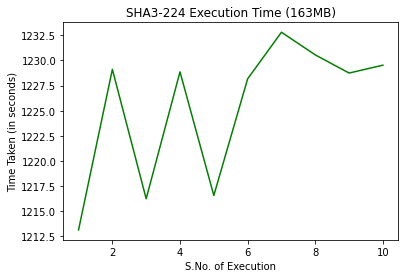

In [15]:
plt.plot(x,execution_times, label="SHA3-224",color="green")
plt.xlabel('S.No. of Execution')
plt.ylabel('Time Taken (in seconds)')
plt.title('SHA3-224 Execution Time (163MB)')